# Extracting historical climate (rainfall) data over selected basins

* **Products used:** 
ERA5

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [27]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.dask import create_local_dask_cluster

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33465 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 3 Memory: 28.14 GB


## Analysis Parameters

In [3]:
# Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f
vector_file = 'data/OB_FWR_Hydrography_Okavango_Subasins_polygon.geojson'

# define time period of interest
time_range = '1989-01', '2009-12'

## Define areas of interest in the Okavango Basin

In [4]:
# load basin polygons
# Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f-caee3d756da9
basin = gpd.read_file(vector_file)

# upstream include Cuito and Cubango subbasins
upstream = basin[basin.Subbasin.isin(['Cuito', 'Cubango'])]
print(upstream)

   CLASS_ID  Longitude   Latitude Subbasin      Sph_Area      Sph_Len  Parts  \
0         0  19.003252 -15.179938    Cuito  5.902293e+10  2285720.103    1.0   
1         0  17.870032 -15.740153  Cubango  1.078813e+11  3071839.684    1.0   

   Vertices                                           geometry  
0    9326.0  POLYGON ((17.85205 -13.53846, 17.85205 -13.536...  
1   11314.0  POLYGON ((15.99370 -13.93323, 15.99370 -13.931...  


## Retrieve historical rainfall data over all areas of interest

In [5]:
# get historical rainfall for upstream and delta
bounds = upstream.total_bounds
lat = bounds[1], bounds[3]
lon = bounds[0], bounds[2]

In [6]:
# download ERA5 rainfall and aggregate to monthly
var = 'precipitation_amount_1hour_Accumulation'
precip = load_era5(var, lat, lon, time_range, reduce_func=np.sum, resample='1D').compute()

# fix inconsistency in axis names
precip = precip.rename({'lat':'latitude', 'lon':'longitude'})

### Create area mask for upstream catchment

In [8]:
upstream_raster = xr_rasterize(upstream, precip, x_dim='longitude', y_dim='latitude')

### Calculate the total rainfall over each area

In [9]:
upstream_rainfall = precip[var].where(upstream_raster).sum(['latitude','longitude'])


### Export results as csv

In [28]:
upstream_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'precipitation_amount_1hour_Accumulation':'cumulative daily rainfall (mm)'},axis=1).to_csv(f'results/upstream_rainfall_daily_{time_range[0]}_to_{time_range[1]}.csv')

### Plot daily rainfall

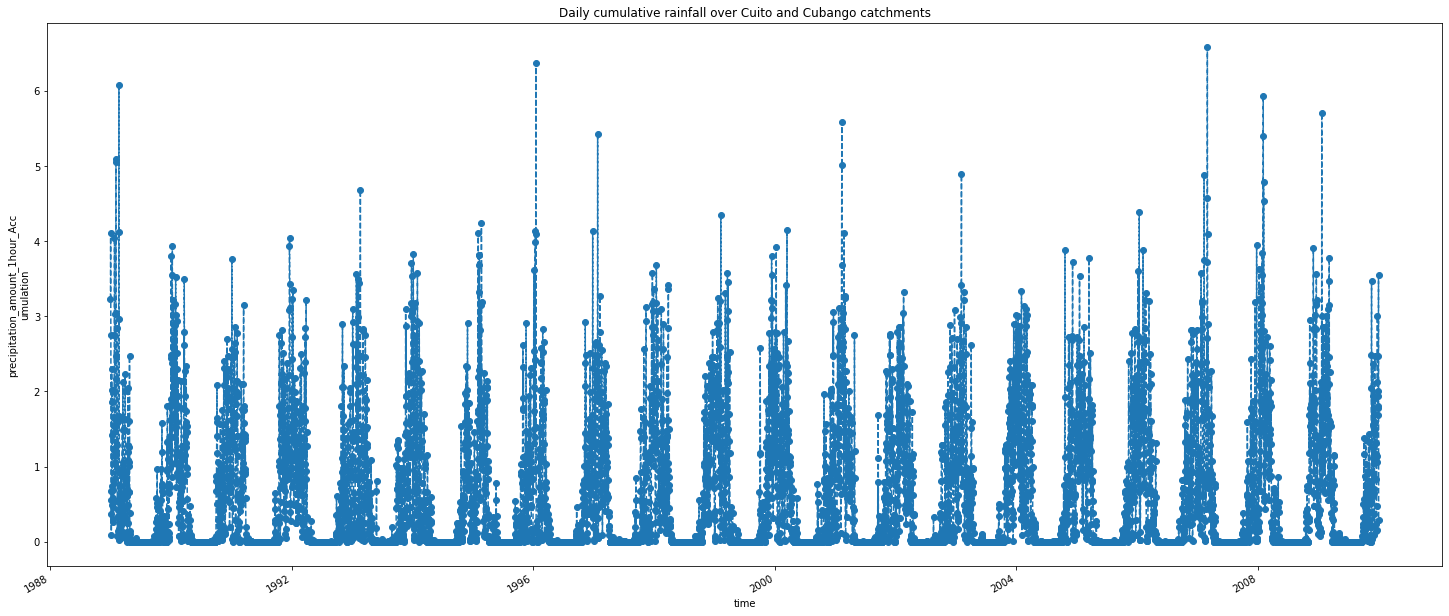

In [24]:
upstream_rainfall.plot(figsize=(25,10), marker='o', linestyle='dashed')
plt.title('Daily cumulative rainfall over Cuito and Cubango catchments');

## Import discharge data

In [29]:
discharge = 'data/mohembo_daily_water_discharge_data.csv'
dis=pd.read_csv(discharge)
dis['date'] = pd.to_datetime(dis['date'], dayfirst=True)
dis = dis.set_index('date')

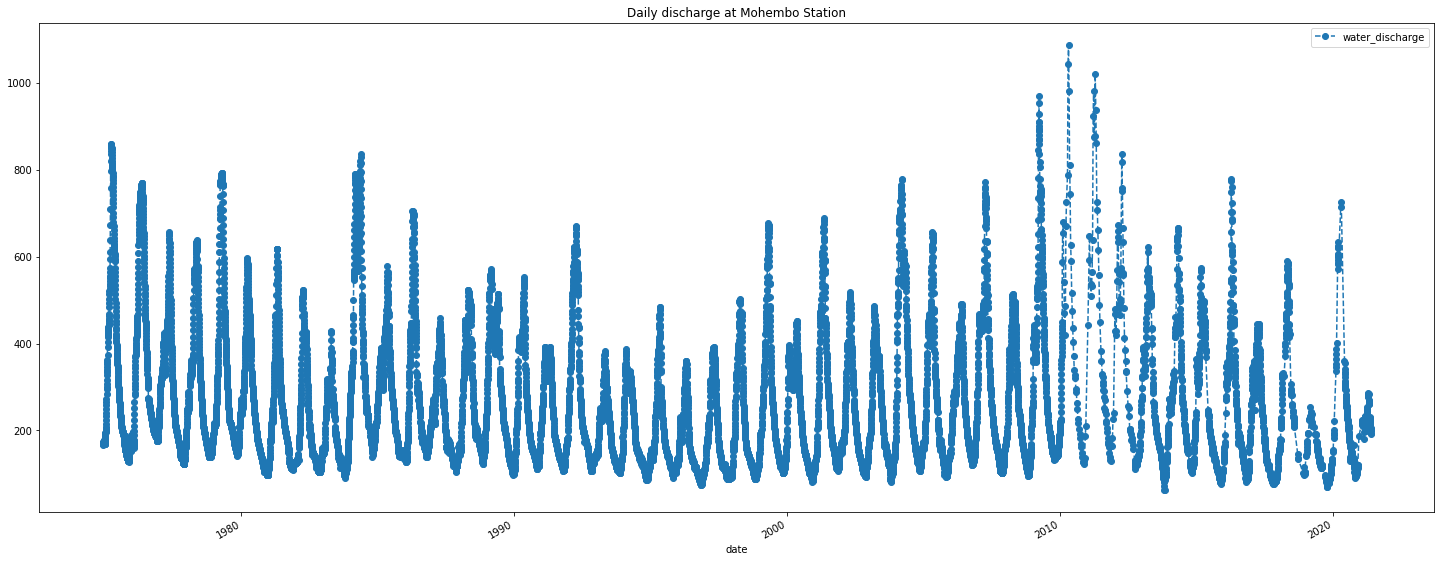

In [33]:
dis.plot(figsize=(25,10),  marker='o', linestyle='dashed')
plt.title('Daily discharge at Mohembo Station');

## Define a model between rainfall and discharge at Mohembo

In [149]:
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

### Match discharge with rainfall

Can set lags with `df.shift(1)`

In [150]:
rain = upstream_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'precipitation_amount_1hour_Accumulation':'cumulative daily rainfall (mm)'},axis=1)
df = rain.join(dis, how='inner')
df.head()

,cumulative daily rainfall (mm),water_discharge
1989-01-01,3.232178,265.93
1989-01-02,4.107727,274.26
1989-01-03,2.748047,286.54
1989-01-04,0.680115,295.05
1989-01-05,0.550232,305.53


### Resample to monthly cumulative totals

This will help with indentifying the best time lag

In [151]:
#total rainfall per month
df = df.resample('M').sum()
df.head()

,cumulative daily rainfall (mm),water_discharge
1989-01-31,45.216431,11713.97
1989-02-28,46.583008,15470.90
1989-03-31,22.774780,14089.42
1989-04-30,22.132874,12032.10
1989-05-31,0.052734,14698.84


### Lagged correlation

In [152]:
def crosscorr(datay, datax, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datay.corr(datax.shift(lag))

[0.013415714807768356, 0.4797188022096249, 0.776930262718756, 0.8211050169841047, 0.6663217801495704, 0.33017872393040865]


### Try a linear model using lagged rainfall

Correlations at each lag: [0.013415714807768356, 0.4797188022096249, 0.776930262718756, 0.8211050169841047, 0.6663217801495704, 0.33017872393040865]


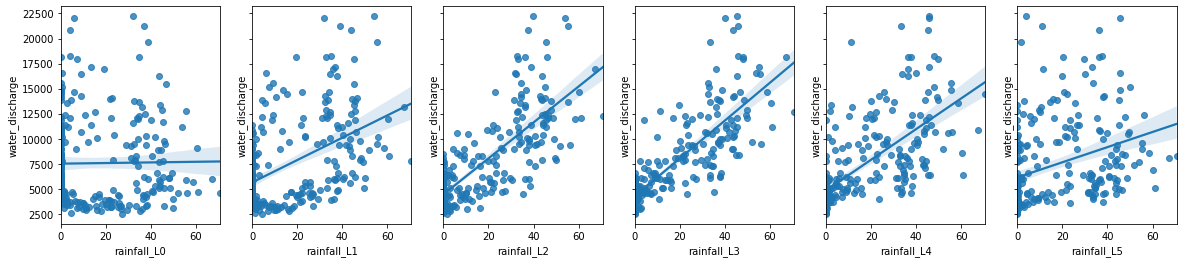

In [183]:
xcov_weekly = [crosscorr(df['water_discharge'], df['cumulative daily rainfall (mm)'], lag=i) for i in range(6)]
print('Correlations at each lag:', xcov_weekly)

fig, ax = plt.subplots(1,6, figsize=(20,4), sharey=True)
for lag in range(6):
    xcovlag = np.argmax(xcov_weekly)
    df['rainfall_L'+str(lag)] = df['cumulative daily rainfall (mm)'].shift(lag)
    sns.regplot(x='rainfall_L'+str(lag), y='water_discharge', data=df, ax=ax[lag]);
    

### Try an ARIMA model

In [127]:
model = ARIMA(endog=df['water_discharge'], exog=df['cumulative daily rainfall (mm)'], order=(4, 1, 0))  # p=2, d=0, q=0 for AR(2)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        water_discharge   No. Observations:                  252
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -2284.521
Date:                Tue, 03 Aug 2021   AIC                           4581.042
Time:                        05:36:43   BIC                           4602.195
Sample:                    01-31-1989   HQIC                          4589.554
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
cumulative daily rainfall (mm)   -42.2270      9.423     -4.481      0.000     -60.695     -23.759
ar.L1                              0.4960      0.051      9.739      0.000       0.396       0.596
ar.L2                             -0.0423      0.052     -0.811      0.417      -0.144       0.060
ar.L3                             -0.1119      0.059     -1.896      0.058      -0.227       0.004
ar.L4                             -0.1285      0.056     -2.286      0.022      -0.239      -0.018
sigma2                          4.647e+06   3.07e+05     15.153      0.000    4.05e+06    5.25e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               104.81
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot the residuals of the model

                  0
count    252.000000
mean      32.605382
std     2334.369820
min    -7863.775844
25%     -965.294168
50%     -176.179041
75%     1220.846676
max    13623.322745


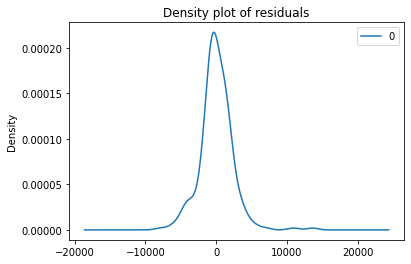

In [129]:
residuals = pd.DataFrame(fit.resid)
print(residuals.describe())
residuals.plot(kind='kde')
plt.title('Density plot of residuals');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')